In [1]:
# ===== Cell 1: Definitions (maze, networks, agent, helpers, enhanced visualization) =====

import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# -- Maze Environment
class MazeEnv:
    def __init__(self, layout, p=0.025, max_steps=50):
        self.layout = np.array(layout)
        self.p = p
        self.max_steps = max_steps
        self.n, self.m = self.layout.shape
        self.actions = [(-1,0),(0,1),(1,0),(0,-1)]  # Up, Right, Down, Left
        self.start = tuple(np.argwhere(self.layout==4)[0])
        self.goal  = tuple(np.argwhere(self.layout==5)[0])
        self._shape = np.array(self.layout.shape) - 1

    def reset(self):
        self.pos = tuple(random.choice(np.argwhere(self.layout==0).tolist()))
        self.steps = 0
        return np.array(self.pos, dtype=np.float32)

    def step(self, action):
        self.steps += 1
        if random.random() < 1 - self.p:
            move = self.actions[action]
        else:
            perp = [self.actions[(action+1)%4], self.actions[(action+3)%4]]
            move = random.choice(perp)
        new = (self.pos[0]+move[0], self.pos[1]+move[1])
        if not (0 <= new[0] < self.n and 0 <= new[1] < self.m) or self.layout[new] == 1:
            new = self.pos
            reward = -1.8
        else:
            cell = self.layout[new]
            reward = -1 if cell==0 else -6 if cell==2 else -11 if cell==3 else 100 if cell==5 else -1
        self.pos = new
        done = (self.pos == self.goal) or (self.steps >= self.max_steps)
        return np.array(self.pos, dtype=np.float32), reward, done

# -- DQN Network with LayerNorm
class DQNNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# -- Dueling DQN Network
class DuelingDQNNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=4):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.adv_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        f = self.feature(x)
        v = self.value_stream(f)
        a = self.adv_stream(f)
        return v + (a - a.mean(dim=1, keepdim=True))

# -- DQN Agent
class DQNAgent:
    def __init__(self, net, lr, gamma, batch_size, memory_size, soft_tau,
                 double=False, update_freq=1, env=None):
        assert env is not None, "Pass env to agent for input normalization"
        self.online = net()
        self.target = net()
        self.target.load_state_dict(self.online.state_dict())
        self.opt = optim.Adam(self.online.parameters(), lr=lr)
        self.gamma = gamma
        self.bs = batch_size
        self.mem = deque(maxlen=memory_size)
        self.tau = soft_tau
        self.double = double
        self.update_freq = update_freq
        self._step_count = 0
        self._shape = torch.FloatTensor(env._shape).unsqueeze(0)

    def select_action(self, s, eps):
        if random.random() < eps:
            return random.randrange(4)
        s_norm = torch.FloatTensor(s).unsqueeze(0) / self._shape
        with torch.no_grad():
            q = self.online(s_norm)
        return int(q.argmax(1))

    def store(self, s, a, r, s2, done):
        self.mem.append((s, a, r, s2, done))

    def update(self):
        if len(self.mem) < self.bs:
            return 0.0
        batch = random.sample(self.mem, self.bs)
        s, a, r, s2, d = zip(*batch)

        s_np = (np.array(s) / env._shape).astype(np.float32)
        s2_np = (np.array(s2) / env._shape).astype(np.float32)
        s_t = torch.from_numpy(s_np)
        s2_t = torch.from_numpy(s2_np)
        a_t = torch.LongTensor(a).unsqueeze(1)
        r_t = torch.FloatTensor(r).unsqueeze(1)
        d_t = torch.FloatTensor(d).unsqueeze(1)

        q_curr = self.online(s_t).gather(1, a_t)
        with torch.no_grad():
            if self.double:
                best = self.online(s2_t).argmax(1, keepdim=True)
                q_next = self.target(s2_t).gather(1, best)
            else:
                q_next = self.target(s2_t).max(1, keepdim=True)[0]
            q_target = r_t + (1 - d_t) * self.gamma * q_next

        loss = nn.functional.mse_loss(q_curr, q_target)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        for p_o, p_t in zip(self.online.parameters(), self.target.parameters()):
            p_t.data.copy_(self.tau * p_o.data + (1 - self.tau) * p_t.data)
        return loss.item()

# -- Training + Reward/Loss plotting
def train(agent, env, episodes):
    R, L = [], []
    step_count = 0
    for k in range(episodes):
        s, done = env.reset(), False
        total_r = total_l = 0
        eps = max(0.1, 0.99 ** k)
        while not done:
            a = agent.select_action(s, eps)
            s2, r, done = env.step(a)
            agent.store(s, a, r, s2, done)
            step_count += 1
            loss = agent.update() if step_count % agent.update_freq == 0 else 0.0
            total_l += loss
            total_r += r
            s = s2
        R.append(total_r)
        L.append(total_l)
    movavg = lambda x: [np.mean(x[max(0, i-24):i+1]) for i in range(len(x))]
    return movavg(R), movavg(L)

def plot_series(data, title):
    plt.figure()
    plt.plot(data)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel(title)
    plt.show()

# -- Policy/value extraction and rollout
def extract_policy(agent, env):
    P = np.zeros(env.layout.shape, dtype=int)
    for i in range(env.n):
        for j in range(env.m):
            if env.layout[i,j] != 1:
                s = torch.FloatTensor([i,j]).unsqueeze(0) / torch.FloatTensor(env._shape).unsqueeze(0)
                with torch.no_grad():
                    q = agent.online(s)
                P[i,j] = int(q.argmax(1))
    return P

def extract_values(agent, env):
    V = np.zeros(env.layout.shape)
    for i in range(env.n):
        for j in range(env.m):
            if env.layout[i,j] != 1:
                s = torch.FloatTensor([i,j]).unsqueeze(0) / torch.FloatTensor(env._shape).unsqueeze(0)
                with torch.no_grad():
                    q = agent.online(s)
                V[i,j] = float(q.max())
    return V

def follow_policy(agent, env):
    state = np.array(env.start, dtype=np.float32)
    env.pos = env.start
    path = [env.start]
    done = False
    while not done:
        action = agent.select_action(state, eps=0.0)
        state, _, done = env.step(action)
        path.append(tuple(state.astype(int)))
    return path

# -- Enhanced Visualization
def plot_policy(P, env, title="Policy"):
    color_map = {0:'white',1:'black',2:'yellow',3:'red',4:'blue',5:'green'}
    arrow_map = {0:'↑',1:'→',2:'↓',3:'←'}
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    for i in range(env.n):
        for j in range(env.m):
            cell = env.layout[i,j]
            ax.add_patch(plt.Rectangle((j, env.n-i-1), 1, 1, color=color_map[cell]))
            if cell not in (1,5):
                ax.text(j+0.5, env.n-i-0.5, arrow_map[P[i,j]], ha='center', va='center', fontsize=14)
    ax.set_title(title)
    ax.set_xlim(0, env.m); ax.set_ylim(0, env.n)
    ax.set_aspect('equal')
    plt.show()

def plot_values(V, env, title="State Values"):
    color_map = {0:'white',1:'black',2:'yellow',3:'red',4:'blue',5:'green'}
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    for i in range(env.n):
        for j in range(env.m):
            cell = env.layout[i,j]
            ax.add_patch(plt.Rectangle((j, env.n-i-1), 1, 1, color=color_map[cell]))
            if cell != 1:
                ax.text(j+0.5, env.n-i-0.5, f"{V[i,j]:.1f}", ha='center', va='center', fontsize=11)
    ax.set_title(title)
    ax.set_xlim(0, env.m); ax.set_ylim(0, env.n)
    ax.set_aspect('equal')
    plt.show()

def plot_path_on_maze(path, env, title="Path from Start to Goal"):
    color_map = {0:'white',1:'black',2:'yellow',3:'red',4:'blue',5:'green'}
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    # Draw cells
    for i in range(env.n):
        for j in range(env.m):
            ax.add_patch(plt.Rectangle((j, env.n-i-1), 1, 1, color=color_map[env.layout[i,j]]))
    # Draw path
    for k in range(len(path)-1):
        x1,y1 = path[k][1], env.n-path[k][0]-1
        x2,y2 = path[k+1][1], env.n-path[k+1][0]-1
        ax.plot([x1+0.5,x2+0.5],[y1+0.5,y2+0.5], linewidth=2)
        ax.plot(x1+0.5,y1+0.5,'o',markersize=4)
    # Goal marker
    ex,ey = path[-1][1], env.n-path[-1][0]-1
    ax.plot(ex+0.5,ey+0.5,'*',markersize=12)
    ax.set_title(title)
    ax.set_xlim(0, env.m); ax.set_ylim(0, env.n)
    ax.set_aspect('equal')
    plt.show()

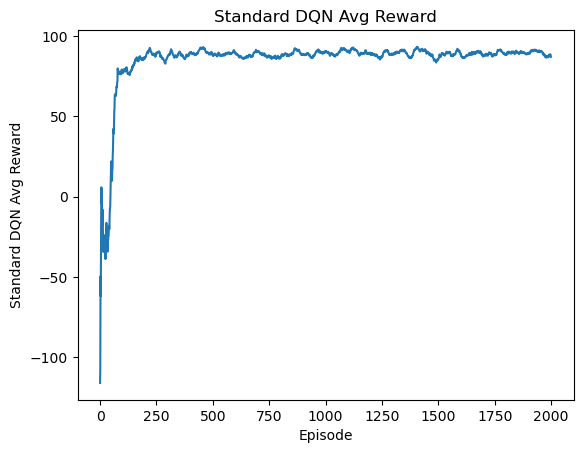

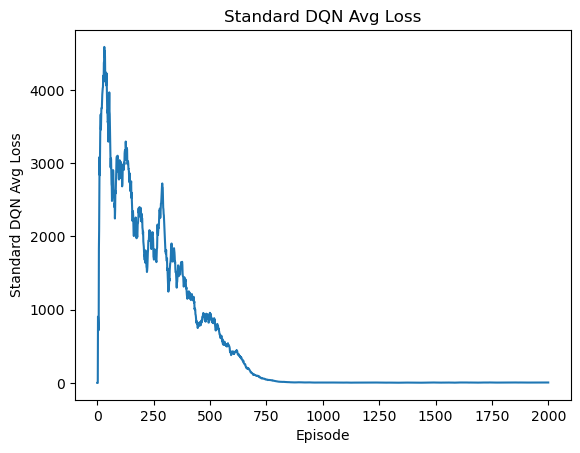

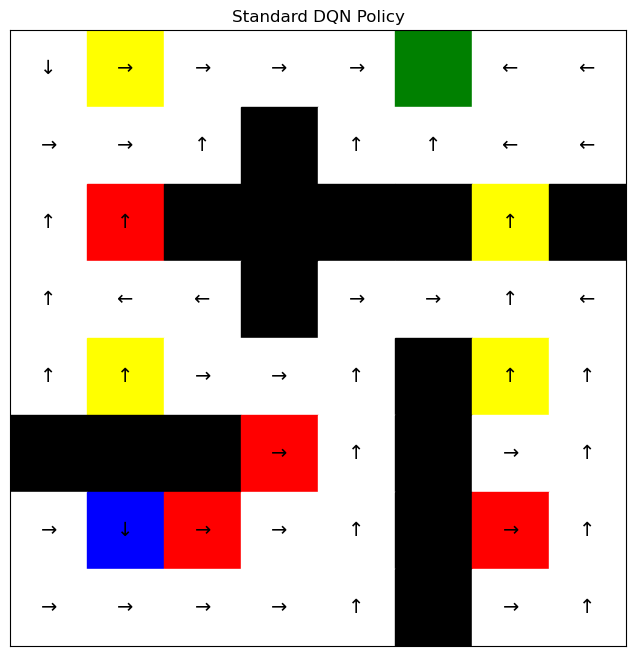

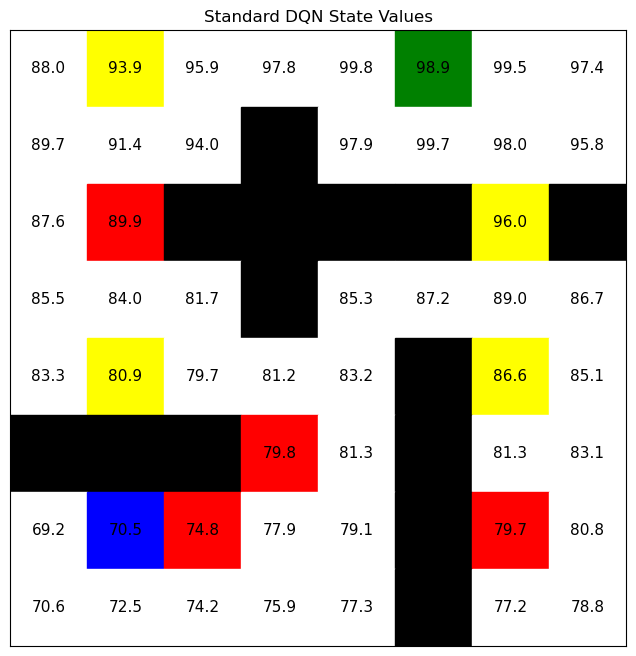

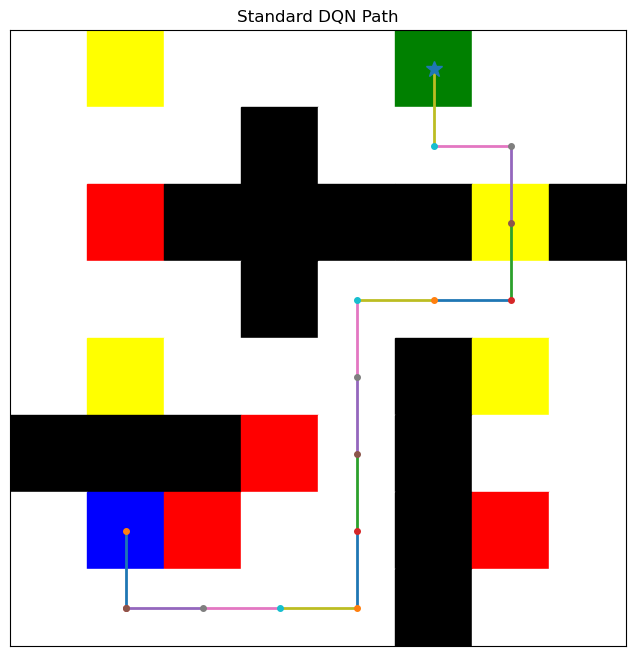

In [4]:
# ===== Cell 2: Run Standard DQN =====

maze = [
    [0,2,0,0,0,5,0,0],
    [0,0,0,1,0,0,0,0],
    [0,3,1,1,1,1,2,1],
    [0,0,0,1,0,0,0,0],
    [0,2,0,0,0,1,2,0],
    [1,1,1,3,0,1,0,0],
    [0,4,3,0,0,1,3,0],
    [0,0,0,0,0,1,0,0],
]
env = MazeEnv(maze, p=0.025, max_steps=50)

std_agent_hp = dict(
    lr=1e-4,
    gamma=0.99,
    batch_size=128,
    memory_size=5000,
    soft_tau=5e-2,
    update_freq=1
)
std_agent = DQNAgent(DQNNetwork, **std_agent_hp, double=False, env=env)

std_r, std_l = train(std_agent, env, episodes=2000)
plot_series(std_r, "Standard DQN Avg Reward")
plot_series(std_l, "Standard DQN Avg Loss")

P_std = extract_policy(std_agent, env)
V_std = extract_values(std_agent, env)
path_std = follow_policy(std_agent, env)

plot_policy(P_std, env, title="Standard DQN Policy")
plot_values(V_std, env, title="Standard DQN State Values")
plot_path_on_maze(path_std, env, title="Standard DQN Path")

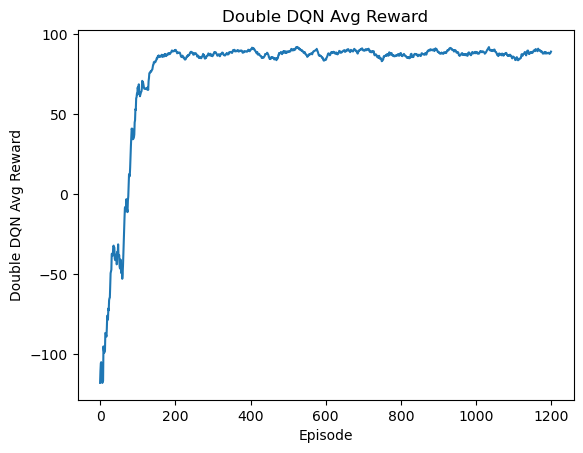

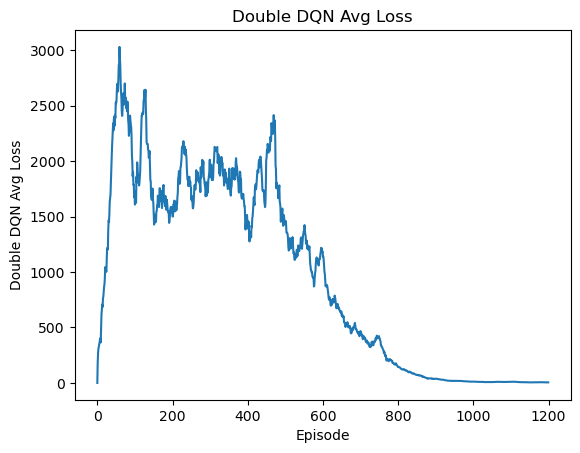

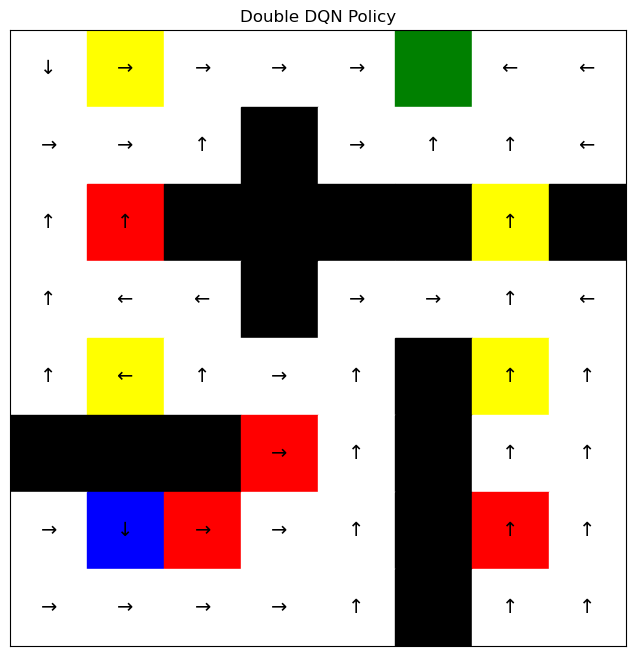

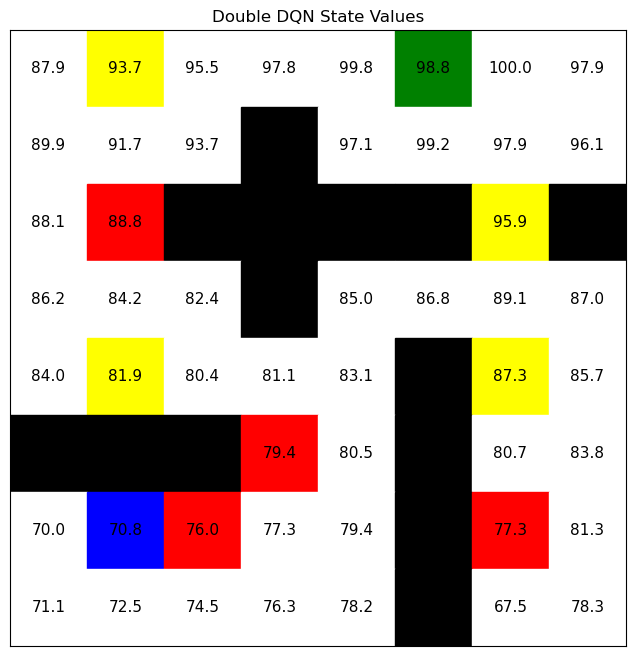

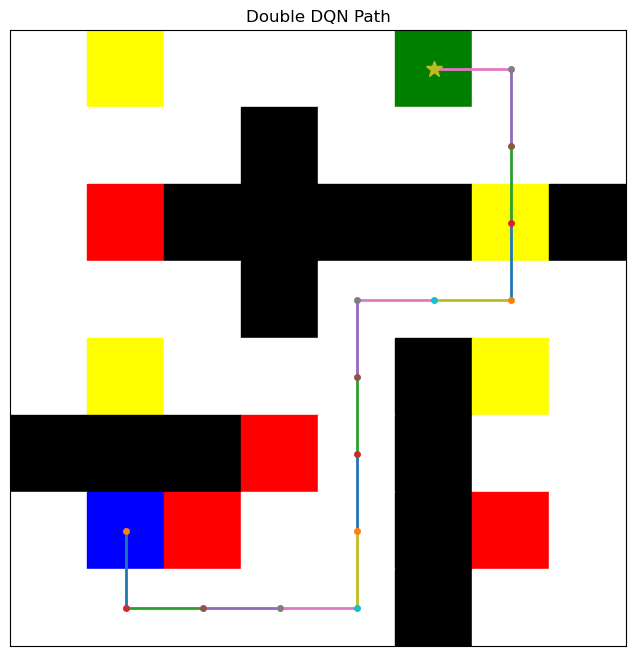

In [6]:
# ===== Cell 3: Run Double DQN =====

env = MazeEnv(maze, p=0.025, max_steps=50)

dd_agent_hp = dict(
    lr=1e-4,
    gamma=0.99,
    batch_size=64,
    memory_size=5000,
    soft_tau=5e-2,
    update_freq=1
)
dd_agent = DQNAgent(DQNNetwork, **dd_agent_hp, double=True, env=env)

dd_r, dd_l = train(dd_agent, env, episodes=1200)
plot_series(dd_r, "Double DQN Avg Reward")
plot_series(dd_l, "Double DQN Avg Loss")

P_dd = extract_policy(dd_agent, env)
V_dd = extract_values(dd_agent, env)
path_dd = follow_policy(dd_agent, env)

plot_policy(P_dd, env, title="Double DQN Policy")
plot_values(V_dd, env, title="Double DQN State Values")
plot_path_on_maze(path_dd, env, title="Double DQN Path")

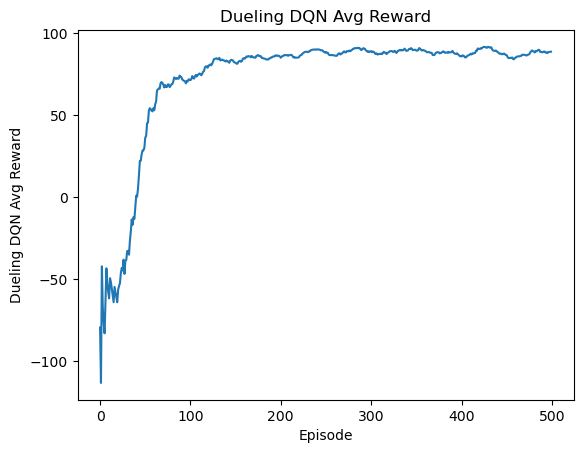

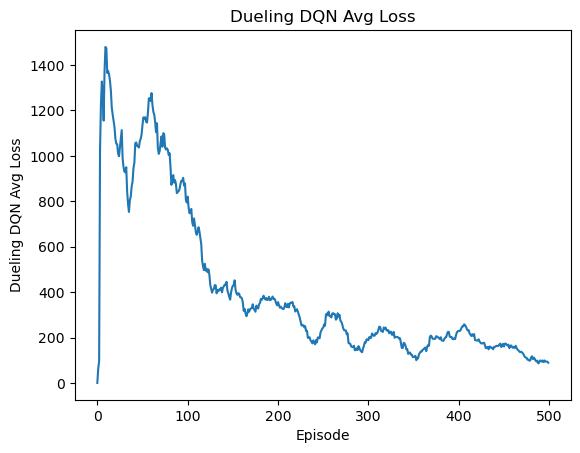

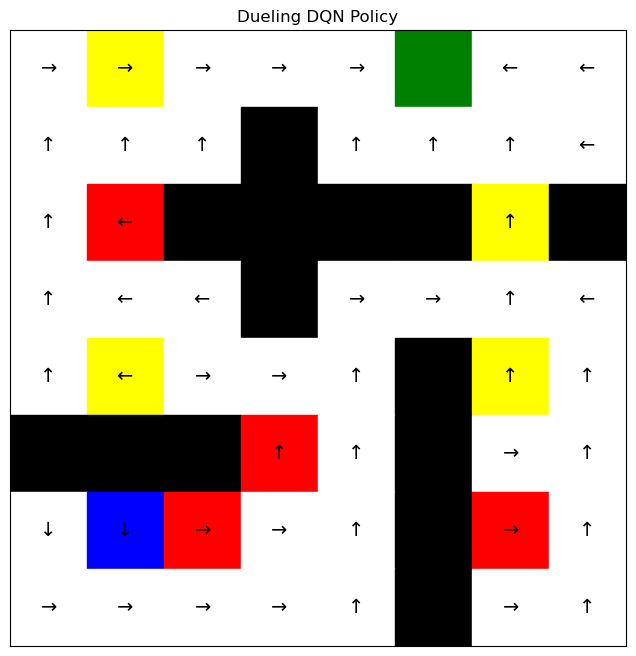

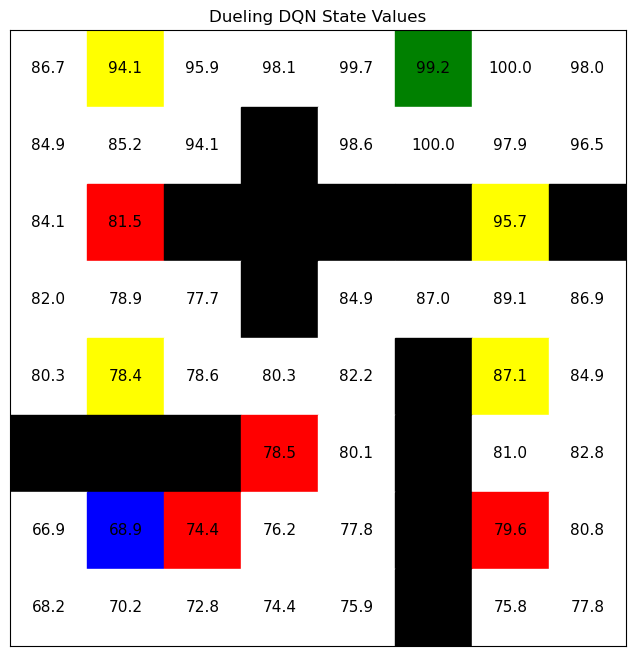

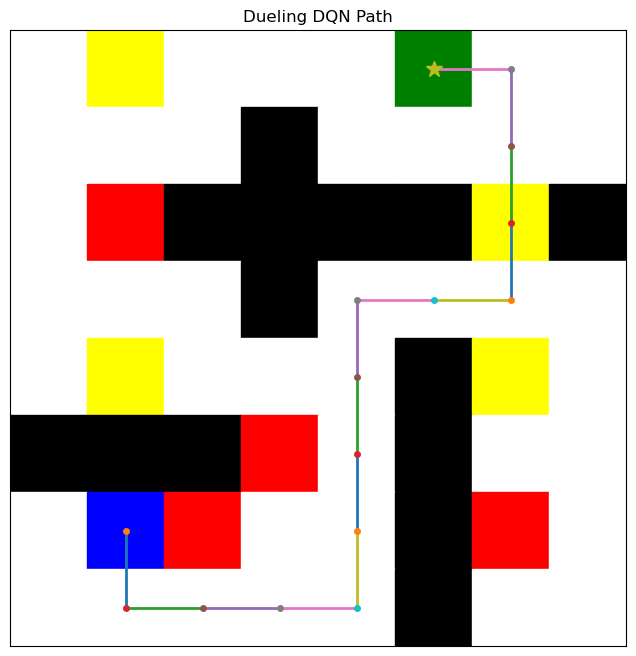

In [8]:
# ===== Cell 4: Run Dueling DQN =====

env = MazeEnv(maze, p=0.025, max_steps=50)

du_agent_hp = dict(
    lr=1e-3,
    gamma=0.99,
    batch_size=64,
    memory_size=5000,
    soft_tau=1e-2,
    update_freq=1
)
du_agent = DQNAgent(DuelingDQNNetwork, **du_agent_hp, double=False, env=env)

du_r, du_l = train(du_agent, env, episodes=500)
plot_series(du_r, "Dueling DQN Avg Reward")
plot_series(du_l, "Dueling DQN Avg Loss")

P_du = extract_policy(du_agent, env)
V_du = extract_values(du_agent, env)
path_du = follow_policy(du_agent, env)

plot_policy(P_du, env, title="Dueling DQN Policy")
plot_values(V_du, env, title="Dueling DQN State Values")
plot_path_on_maze(path_du, env, title="Dueling DQN Path")